In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
import numpy as np
import nibabel as nib
import os
import pickle
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Function, Variable
from tqdm import tqdm
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.cuda.get_device_name()

'GeForce GTX 1660 Ti'

In [4]:
'''def ELU(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)
    
def n_conv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(single_conv(nchan, elu))
    return nn.Sequential(*layers)'''


class single_conv(nn.Module):
    def __init__(self, inchan, outchan):
        super(single_conv, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv3d(inchan, outchan, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(outchan)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out


In [5]:
class input_layer(nn.Module):
    def __init__(self, inchan, outchan):
        super(single_conv, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv3d(inchan, outchan, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(outchan)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out
    

In [6]:
'''class down_layer(nn.Module):
    def __init__(self, in_ch, nConv, elu):
        super(down_layer, self).__init__()
        out_ch = 2*in_ch
        self.down_conv = nn.Conv3d(in_ch, out_ch, kernel_size=2, stride=2)
        self.bn = nn.BatchNorm3d(out_ch)
        self.relu = ELU(elu, out_ch)
        #self.layers = n_conv(out_ch, nConv, elu)
        
    def forward(self, x):
        down = self.relu(self.bn(self.down_conv(x)))
        #out = self.layers(down)
        out = self.relu(down)
        return down, out'''
    
class down(nn.Module):
    def __init__(self):
        super(down, self).__init__()
        self.down = nn.MaxPool3d((2,2,2)) 
    def forward(self, x):
        x = self.down(x)
        return x

In [7]:
'''class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch, nConv, elu):
        super(up_layer, self).__init__()
        self.up_conv = nn.ConvTranspose3d(in_ch, out_ch//2 , kernel_size=2, stride=2)
        self.bn = nn.BatchNorm3d(out_ch//2 )
        self.relu1 = ELU(elu, out_ch//2 )
        self.relu2 = ELU(elu, out_ch)
        #self.layers = n_conv(out_ch, nConv, elu)
        #self.do2 = nn.Dropout3d()

    def forward(self, x, skipx):
        out = self.relu1(self.bn(self.up_conv(x)))
        #print('after out', out.shape)
        #skipxdo = self.do2(skipx)
        #print('after do2', skipxdo.shape)
        xcat = torch.cat((out, skipx), 1)
        #print('after xcat', xcat.shape)
        out = self.layers(xcat)
        #print('after layers', out.shape)
        out = self.relu2(torch.add(out, xcat))
        #print('after relu2', out.shape)
        return out'''
    
class up(nn.Module):
    def __init__(self):
        super(up, self).__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'trilinear') # use nn.Upsample() with mode bilinear
    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x1 = self.up(x1)
        # This part is tricky so we've completed this
        # Notice that x2 and x1 may not have the same spatial size.
        # This is because when you downsample old_x2(say 25 by 25), you will get x1(12 by 12)
        # Then you perform upsample to x1, you will get new_x1(24 by 24) 3/26/2020 CA04_UNet_TEMPLATEfile:///Users/admin/Downloads/CA04_UNet_TEMPLATE.html 4/29
        # You should pad a new row and column so that new_x1 and x2 have the same size.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2, diffZ // 2, diffZ - diffZ//2))
        # Now we concatenat x2 and x1 along channel dimension: torch.cat()
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat((x2,x1),1)
        return x

In [8]:
'''class output_layer(nn.Module):
    def __init__(self, in_ch, elu, nll):
        super(output_layer, self).__init__()
        self.conv1 = nn.Conv3d(in_ch, 2, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(2)
        self.conv2 = nn.Conv3d(2, 1, kernel_size=1)
        self.relu1 = ELU(elu, 1)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.softmax = F.softmax

    def forward(self, x):
        out = self.relu1(self.bn(self.conv1(x)))
        out = self.conv2(out)
        #out = out.permute(0, 2, 3, 4, 1).contiguous()
        #out = out.view(out.numel() // 2, 2)
        out = self.softmax(out)
        return out'''

    
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size = 1)
    def forward(self, x):
        #x = np.pad(x, ((0,2),(0,2),(0,2)), 'constant')
        x = self.conv(x)
        # Apply sigmoid activation: torch.sigmoid()
        x = torch.sigmoid(x)
        return x



In [9]:
'''class VNet(nn.Module):
    
    def __init__(self, elu=True, nll=False):
        super(VNet, self).__init__()
        #In
        self.input = input_layer(1, 16, elu)
        
        #Down
        self.down32 = down_layer(16, 2, elu)
        self.down64 = down_layer(32, 3, elu)
        self.down128 = down_layer(64, 3, elu)
        #self.down256 = down_layer(128, 3, elu)
        
        #Up
        #self.up256 = up_layer(256,256, 3, elu)
        self.up128 = up_layer(128,128, 3, elu)
        self.up64 = up_layer(128,64, 2, elu)
        self.up32 = up_layer(64,32, 1, elu)
        
        #Out
        self.output = output_layer(32, elu, nll)
    
    def forward(self, x):
        #Layer 1: In
        out16 = self.input(x)
        
        #Layer 2 : Down ( 2 conv layers deep)
        d_32, out32 = self.down32(out16)
        
        #Layer 3 : Down ( 3 conv layers deep)
        d_64, out64 = self.down64(out32)
        
        #Layer 4 : Down ( 3 conv layers deep)
        d_128, out128 = self.down128(out64)      
        
        #Layer 5 : Down ( 3 conv layers deep)
        #d_256, out256 = self.down256(out128)
        
        #Layer 5 : up ( 3 conv layers deep)
        #output = self.up256(out256, out128)
        #print(output.shape)
        #Layer 4 : up ( 3 conv layers deep)
        output = self.up128(out128, out64)
        
        #Layer 3 : up ( 3 conv layers deep)
        output = self.up64(output, out32)
        
        #Layer 2 : up ( 2 conv layers deep)
        output = self.up32(output, out16)
        
        #Layer 1 : out
        output = self.output(output)
        
        return output'''
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        ## Define the necessary layers using the classes defined above
        self.conv_1_16 = single_conv(1,16)
        self.down = down()
        self.up = up()
        self.conv_16_32 = single_conv(16,32)
        self.conv_32_32 = single_conv(32,32)
        self.conv_64_16 = single_conv(64,16)
        self.conv_32_16 = single_conv(32,16)
        self.outconv = outconv(16,1)
        
    def forward(self, x):
        # Define forward pass
        x1 = self.conv_1_16(x)
        #print(x1.shape)
        x1d = self.down(x1)
        #print(x1d.shape)
        x2 = self.conv_16_32(x1d)
        #print(x2.shape)
        x2d = self.down(x2)
        #print(x2d.shape)
        x3 = self.conv_32_32(x2d)
        #print(x3.shape)
        x4 = self.up(x3,x2)
        #print(x4.shape)
        x5 = self.conv_64_16(x4)
        #print(x5.shape)
        x6 = self.up(x5,x1)
        #print(x6.shape)
        x7 = self.conv_32_16(x6)
        #print(x7.shape)
        x = self.outconv(x7)
        #print(x.shape)
        return x

In [10]:
net = UNet()
#print(model)

In [11]:
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

Number of parameters in network:  386353


In [12]:
# Path to the folder that contains folders of segmentation data
PATH = "data/TrainingDataset_MSSEG/"
# Takes all folders in the path 
PATH = PATH + "*/"
image_paths = []
mask_paths = []

block_size = (32,32,32)

directory_paths = glob(PATH)
for path in directory_paths:
    # Load all the paths for each Flair set of data (1 Flair data and all its segmentation paths)
    flair_path = path + '3DFLAIR.nii.gz'
    seg1_path = path + 'ManualSegmentation_1.nii.gz'
    seg2_path = path + 'ManualSegmentation_2.nii.gz'
    seg3_path = path + 'ManualSegmentation_3.nii.gz'
    seg4_path = path + 'ManualSegmentation_4.nii.gz'
    seg5_path = path + 'ManualSegmentation_5.nii.gz'
    seg6_path = path + 'ManualSegmentation_6.nii.gz'
    seg7_path = path + 'ManualSegmentation_7.nii.gz'
    image_paths.extend([flair_path])#,flair_path,flair_path,flair_path,flair_path,flair_path,flair_path])
    mask_paths.extend([seg1_path])#,seg2_path,seg3_path,seg4_path,seg5_path,seg6_path,seg7_path])
    
#print(image_paths)
#print(mask_paths)

In [13]:
def split_train_val(image_paths, mask_paths, train_size):
    img_paths_dic = {}
    mask_paths_dic = {}
    len_data = len(image_paths)
    print('total len:', len_data)
    p = 0
    q = 0
    for i in range(len(image_paths)):
        img_paths_dic[str(p)+'_'+str(q)] = image_paths[i]
        if q==6:
            q=0
            p=p+1
        else:
            q=q+1
    
    p = 0
    q = 0
    for i in range(len(mask_paths)):
        mask_paths_dic[str(p)+'_'+str(q)] = mask_paths[i]
        if q==6:
            q=0
            p=p+1
        else:
            q=q+1
        
    img_mask_list = []
    #print(img_paths_dic)
    
    for key in img_paths_dic:
        img_mask_list.append((img_paths_dic[key], mask_paths_dic[key]))
        
    train_img_mask_paths = img_mask_list[:int(len_data*train_size)] 
    val_img_mask_paths = img_mask_list[int(len_data*train_size):]
    return train_img_mask_paths, val_img_mask_paths



In [14]:
def zero_padding(data, block_size):
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[0]/block_size[0])
    #Calculate required padding size 
    pad_val_c = (block_size[0] * ceil_val) - data.shape[0]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[1]/block_size[1])
    #Calculate required padding size
    pad_val_h = (block_size[1] * ceil_val) - data.shape[1]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[2]/block_size[2])
    # Calculate required padding size
    pad_val_w = (block_size[2] * ceil_val) - data.shape[2]
    
    # Constant padding
    #data = data.numpy()
    data = np.pad(data, ((0,pad_val_c),(0,pad_val_h),(0,pad_val_w)), 'constant')
    #data = np.array(data, dtype=np.int16)
    
    #changed dtype to float
    data = np.array(data, dtype=np.float32)
    return data


def get_data_blocks(data, block_size ):
    x = torch.from_numpy(data)
    # Add a dimension at 0th position
    x = x.unsqueeze(0)
    # Kernel Size
    kc, kh, kw = block_size[0], block_size[1], block_size[2]
    # stride
    dc, dh, dw = block_size[0], block_size[1], block_size[2]
    patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    unfold_shape = patches.size()
    patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
    #Return Patches and Unfold Shape
    return patches, unfold_shape

In [15]:
"""from collections import defaultdict as dd

def preprocess_image(image_mask_paths):
    img_mask_list = []

    for i in tqdm(range(len(image_mask_paths))):
        vol = nib.load(image_mask_paths[i][0])
        m = nib.load(image_mask_paths[i][1])
        img = np.array(vol.get_data(), np.float32) / 255.0
        mask = np.array(m.get_data(),np.uint8)
        img_mask_list.append((img, mask))

    return img_mask_list"""


'from collections import defaultdict as dd\n\ndef preprocess_image(image_mask_paths):\n    img_mask_list = []\n\n    for i in tqdm(range(len(image_mask_paths))):\n        vol = nib.load(image_mask_paths[i][0])\n        m = nib.load(image_mask_paths[i][1])\n        img = np.array(vol.get_data(), np.float32) / 255.0\n        mask = np.array(m.get_data(),np.uint8)\n        img_mask_list.append((img, mask))\n\n    return img_mask_list'

In [16]:

def preprocess_image(image_mask_paths):
    img_mask_list = []

    for i in tqdm(range(len(image_mask_paths))):
        vol = nib.load(image_mask_paths[i][0])
        m = nib.load(image_mask_paths[i][1])
        img = np.array(vol.get_data(), np.float32)
        img = img / np.amax(img)
        img_padded = np.pad(img, ((0,2),(0,2),(0,2)), 'constant')
        mask = np.array(m.get_data(),np.uint8)
        mask = mask / np.amax(mask)
        mask_padded = mask
        #mask_padded = zero_padding(mask, block_size)

        # Generate data blocks of block_size
        img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
        mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

        img_array = img_blocks.numpy()
        mask_array = mask_blocks.numpy()
        per_img = []
        per_mask = []
        if i<1:
            for j in range(len(img_array[0])):
                if np.sum(mask_array[0][j])>0:
                    img_mask_list.append((img_array[0][j], mask_array[0][j]))
                #print(img_array[0][i].shape)
        else:
            for j in range(len(img_array[0])):
                if np.sum(mask_array[0][j])>0:
                    img_mask_list.append((img_array[0][j], mask_array[0][j]))

    return img_mask_list 

In [36]:
train_img_mask_paths, val_img_mask_paths = split_train_val(image_paths[:2], mask_paths[:2], 0.95)

print(train_img_mask_paths)
#Training:
train_img_masks = preprocess_image(train_img_mask_paths)

#Validation:
val_img_masks = preprocess_image(val_img_mask_paths)

  0%|          | 0/1 [00:00<?, ?it/s]

total len: 2
[('data/TrainingDataset_MSSEG\\01016SACH\\3DFLAIR.nii.gz', 'data/TrainingDataset_MSSEG\\01016SACH\\ManualSegmentation_1.nii.gz')]


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


In [61]:
print(len(train_img_mask_paths))

1


In [43]:
"""train_img_mask_paths, val_img_mask_paths = split_train_val(image_paths, mask_paths, 0.95)

def pickle_store(file_name,save_data):
    fileObj = open(file_name,'wb')
    pickle.dump(save_data,fileObj)
    fileObj.close()

train_img_masks_save_path = './train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    train_img_masks = preprocess_image(train_img_mask_paths)
    pickle_store(train_img_masks_save_path, train_img_masks)
print('train len: {}'.format(len(train_img_masks)))"""

"train_img_mask_paths, val_img_mask_paths = split_train_val(image_paths, mask_paths, 0.95)\n\ndef pickle_store(file_name,save_data):\n    fileObj = open(file_name,'wb')\n    pickle.dump(save_data,fileObj)\n    fileObj.close()\n\ntrain_img_masks_save_path = './train_img_masks.pickle'\nif os.path.exists(train_img_masks_save_path):\n    with open(train_img_masks_save_path,'rb') as f:\n        train_img_masks = pickle.load(f)\n    f.close()\nelse:\n    train_img_masks = preprocess_image(train_img_mask_paths)\n    pickle_store(train_img_masks_save_path, train_img_masks)\nprint('train len: {}'.format(len(train_img_masks)))"

In [44]:
"""# For validation data
val_img_masks_save_path = './val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    val_img_masks = preprocess_image(val_img_mask_paths)
    pickle_store(val_img_masks_save_path,val_img_masks)
print('val len: {}'.format(len(val_img_masks)))"""

"# For validation data\nval_img_masks_save_path = './val_img_masks.pickle'\nif os.path.exists(val_img_masks_save_path):\n    with open(val_img_masks_save_path,'rb') as f:\n        val_img_masks = pickle.load(f)\n    f.close()\nelse:\n    val_img_masks = preprocess_image(val_img_mask_paths)\n    pickle_store(val_img_masks_save_path,val_img_masks)\nprint('val len: {}'.format(len(val_img_masks)))"

In [45]:
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']
        image = image[None,:,:]
        label = label[None,:,:]
#         image = image.numpy()
#         label = label.numpy()
        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [46]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None):

        self.image_masks = image_masks
        self.transforms = transforms

    def __len__(self):  # return count of sample we have

        return len(self.image_masks)

    def __getitem__(self, index):

        image = self.image_masks[index][0] # H, W, C
        mask = self.image_masks[index][1]

#         image = np.transpose(image, axes=[2, 0, 1]) # C, H, W

        sample = {'img': image, 'label': mask}

        if transforms:
            sample = self.transforms(sample)

        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([ToTensor()]))

In [47]:

# define dice coefficient 
class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, prediction, target):
        self.save_for_backward(prediction, target)
        eps = 0.0001 # in case union = 0
        # Calculate intersection and union. 
        # You can convert the input image into a vector with input.contiguous().view(-1)
        # Then use torch.dot(A, B) to calculate the intersection.
        A = prediction.view(-1)
        B = target.view(-1)
        inter = torch.dot(A.float(),B.float())
        union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps
        # Calculate DICE 
        d = inter / union
        return d

# Calculate dice coefficients for batches
def dice_coeff(prediction, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
    
    # For each pair of input and target, call DiceCoeff().forward(prediction, target) to calculate dice coefficient
    # Then average
    for i, (a,b) in enumerate(zip(prediction, target)):
        s += DiceCoeff().forward(a,b)
    s = s / (i + 1)
    return s


In [48]:
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    print("val dataset length:", len(dataset))
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[0]
        true_mask = b['label'].to(device)

        # Feed the image to the network to get predicted mask
        mask_pred = net(img.float())

        # For all pixels in predicted mask, set them to 1 if larger than 0.5. Otherwise set them to 0
        mask_pred = mask_pred > 0.5
        # calculate dice_coeff()
        # note that you should add all the dice_coeff in validation/testing dataset together
        # call dice_coeff() here
        masks_probs_flat = mask_pred.view(mask_pred.numel())
        true_masks_flat = true_mask.view(true_mask.numel())
        
        tot += dice_coeff(true_masks_flat,masks_probs_flat)
        #tot += dice_coeff(true_mask,mask_pred)
        # Return average dice_coeff()
    return tot / (i + 1)


In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [51]:
from torch import optim
epochs = 50 # e.g. 10, or more until dice converge
batch_size = 5 # e.g. 16
lr = 0.01        # e.g. 0.01
N_train = len(train_img_masks)
model_save_path = 'model/'  # directory to same the model after each epoch.

optimizer = optim.SGD(net.parameters(),lr = lr,momentum=0.9, weight_decay=0.0005)

criterion = nn.BCELoss()
net.to(device)
# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    epoch_loss = 0
    count = 0

    for i, b in enumerate(train_loader):
        # Get images and masks from each batch

        imgs = b['img'].to(device)
        true_masks = b['label'].to(device)
        #print('True mask shape: ',true_masks.shape)
        # Feed your images into the network
        masks_pred = net.forward(imgs.float())
        #print('Predicted mask shape: ',masks_pred.shape)
        #masks_pred = nn.functional.interpolate(masks_pred, size=true_masks.shape, mode='bilinear')
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        #masks_probs_flat = masks_pred.view(-1)
        #true_masks_flat = true_masks.view(-1)
        #print('true_masks: ',true_masks.shape)
        #print('masks_pred: ',masks_pred.shape)
        masks_probs = masks_pred[:,0,:,:,:]
        masks_probs = masks_probs.unsqueeze(1)
        #print(masks_probs.shape)
        
        #masks_probs_flat = np.transpose(masks_probs_flat, axes=[1, 0, 2, 3, 4])
        #masks_probs_flat = masks_probs_flat[0]
        #masks_probs_flat = masks_probs.view(masks_probs.numel())
        #true_masks_flat = true_masks.view(true_masks.numel())
        
        masks_probs_flat = masks_probs.reshape(1,-1)
        masks_probs_flat = masks_probs_flat.squeeze()
        
        true_masks_flat = true_masks.reshape(1,-1)
        true_masks_flat = true_masks_flat.squeeze()
        
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together
        loss = criterion(masks_probs_flat,true_masks_flat.float())
        epoch_loss += loss.item()
        if count % 50 == 0:
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))
        count = count + 1
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer.
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True.
        # These are accumulated into x.grad for every parameter x
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad.
        optimizer.step()
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))

    # Perform validation with eval_net() on the validation data
    #val_dice = eval_net(net,val_loader)
    #print('Validation Dice Coeff: {}'.format(val_dice))
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))


Starting epoch 1/50.
0.0000 --- loss: 0.050037
Epoch finished ! Loss: 0.08891900095411322
Checkpoint 1 saved !
Starting epoch 2/50.
0.0000 --- loss: 0.039278
Epoch finished ! Loss: 0.08628485207869248
Checkpoint 2 saved !
Starting epoch 3/50.
0.0000 --- loss: 0.036619
Epoch finished ! Loss: 0.08209210981360891
Checkpoint 3 saved !
Starting epoch 4/50.
0.0000 --- loss: 0.032557
Epoch finished ! Loss: 0.07843340747058392
Checkpoint 4 saved !
Starting epoch 5/50.
0.0000 --- loss: 0.027714
Epoch finished ! Loss: 0.07623630144040693
Checkpoint 5 saved !
Starting epoch 6/50.
0.0000 --- loss: 0.026091
Epoch finished ! Loss: 0.0746902769685469
Checkpoint 6 saved !
Starting epoch 7/50.
0.0000 --- loss: 0.026541
Epoch finished ! Loss: 0.07508760356259617
Checkpoint 7 saved !
Starting epoch 8/50.
0.0000 --- loss: 0.026693
Epoch finished ! Loss: 0.07661735063249414
Checkpoint 8 saved !
Starting epoch 9/50.
0.0000 --- loss: 0.029316
Epoch finished ! Loss: 0.07632800598036159
Checkpoint 9 saved !
St

In [52]:
def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()

    # convert from Height*Width*Channel TO Channel*Height*Width
    #full_img = np.transpose(full_img,[2,0,1])

    # convert numpy array to torch tensor, normalize to range (0,1)
    full_img = full_img/np.amax(full_img)
    X_img = torch.from_numpy(full_img).unsqueeze(0).unsqueeze(0).to(device)
    

    with torch.no_grad():

        output_img = net(X_img.float())
        #out_probs = output_img.squeeze(0).squeeze(0)
        masks_probs = output_img.mean(0) # removes channel
        masks_probs = masks_probs[0] # consider output[0]
        # threshold the probability to generate mask: mask=1 if prob > out_threshold, set mask to uint8
        out_mask_np = (masks_probs>out_threshold).cpu().numpy().astype('uint8')

    return out_mask_np

In [53]:
def reconstruct(blocks, unfold_shape):

    blocks_orig = blocks.view(unfold_shape)
    output_c = unfold_shape[1] * unfold_shape[4]
    output_h = unfold_shape[2] * unfold_shape[5]
    output_w = unfold_shape[3] * unfold_shape[6]
    blocks_orig = blocks_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    blocks_orig = blocks_orig.view(1, output_c, output_h, output_w)
    # Remove the dimension at 0th position and convert to numpy
    blocks_orig = blocks_orig.squeeze(0).detach().numpy()
    return blocks_orig

In [56]:
# Load an image from testing dataset
test_img_paths = "data/TrainingDataset_MSSEG/01016SACH/3DFLAIR.nii.gz"
test_mask_paths = "data/TrainingDataset_MSSEG/01016SACH/ManualSegmentation_1.nii.gz"
vol = nib.load(test_img_paths)
vol_affine = vol.affine
m = nib.load(test_mask_paths)
img = np.array(vol.get_data(), np.float32)
img = img/np.amax(img)
img_padded = zero_padding(img, block_size)
mask_orig = np.array(m.get_data(),np.uint8)
mask_orig = mask_orig/np.amax(mask_orig)
#mask_padded = zero_padding(mask, block_size)

# Generate data blocks of block_size
img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
#mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

img_array = img_blocks.numpy()
test_img = []


for i in range(len(img_array[0])):
    test_img.append(img_array[0][i])
#test_img_mask = preprocess_image(test_img_paths)

orig_shape = len(test_img)
print(len(test_img))

#img_resize = cv2.resize(test_img_mask,(100,80))
predicted = []
for image in test_img:

    # Predict the mask
    mask_pred = predict_img(net=net,full_img=image, out_threshold=0.5)
    # Rescale the mask back to original image size
    #print(mask_pred.shape)
    predicted.append(mask_pred)

pred = torch.from_numpy(np.asarray(predicted)).type(torch.FloatTensor)
mask_recon = reconstruct(pred,unfold_shape_img)


1280


In [57]:

#Segment
mask_recon = torch.from_numpy(np.asarray(mask_recon)).type(torch.FloatTensor)
mask_interpolated = nn.functional.interpolate(mask_recon.unsqueeze(0).unsqueeze(0), size=img.shape, mode='trilinear')
img_seg = mask_interpolated #* img
img_seg = img_seg.squeeze().squeeze().numpy()
img_seg_original = mask_orig#*img

print(img_seg.shape)
print(img.shape)
print(img_seg_original.shape)


import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(10,10))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

(144, 512, 512)
(144, 512, 512)
(144, 512, 512)


Text(0.5, 0.98, 'Center slices for MRI image')

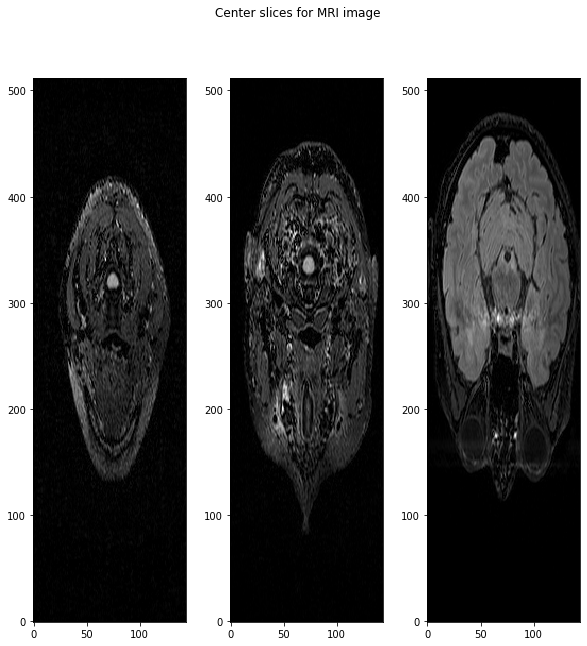

In [58]:
slice_0 = img[:, :, 87]
slice_1 = img[:, :, 174]
slice_2 = img[:, :, 261]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image")

Text(0.5, 0.98, 'Center slices for MRI image segmented by prediction')

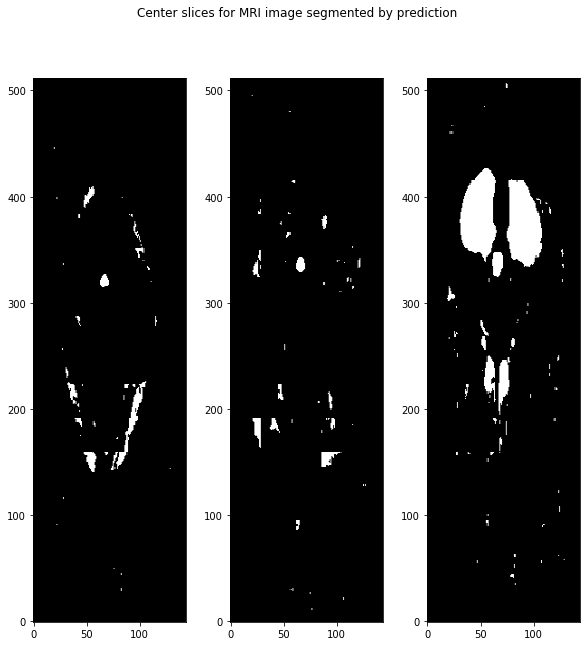

In [59]:
slice_0 = img_seg[:, :, 87]
slice_1 = img_seg[:, :, 174]
slice_2 = img_seg[:, :, 200]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented by prediction")

Text(0.5, 0.98, 'Center slices for MRI image segmented original')

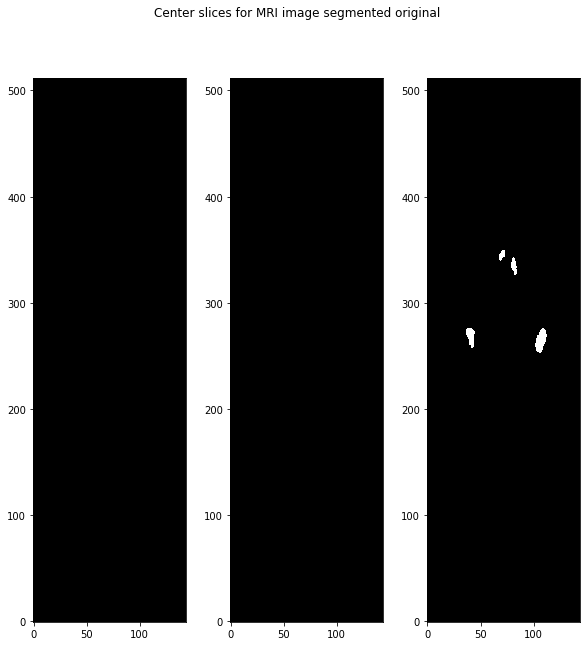

In [60]:
slice_0 = img_seg_original[:, :, 87]
slice_1 = img_seg_original[:, :, 174]
slice_2 = img_seg_original[:, :, 261]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented original")

In [34]:
import time

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

14:30:51


In [35]:
print(img_seg.shape, np.sum(img_seg), np.amax(img_seg))

(261, 336, 336) 2964234.5 1.0
